In [10]:
import numpy as np
import pandas as pd
from utils import Options
from mvpa.loading import load_betas
from mvpa.mvpa_utils import split_expunexp
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, plot_glass_brain
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import get_clusters_table
import nibabel as nb
from glob import glob

In [11]:
all_maps = sorted(glob('../../FIR_correlations/ba-17-18_contr-objscrvsbas_top-500/*.nii'))
exp_maps = [m for m in all_maps if 'unexp' not in m]
unexp_maps = [m for m in all_maps if 'unexp' in m]

In [12]:
allexp = []
allunexp = []
alldiffs = []
for em, um in zip(exp_maps, unexp_maps):
    thisexp = nb.load(em).get_fdata()[:,:,:,np.newaxis]
    allexp.append(thisexp)
    thisunexp = nb.load(um).get_fdata()[:,:,:,np.newaxis]
    allunexp.append(thisunexp)
    alldiffs.append(thisexp - thisunexp)
allexp = np.concatenate(allexp, axis=3)
allunexp = np.concatenate(allunexp, axis=3)
alldiffs = np.concatenate(alldiffs, axis=3)
meanexp = np.mean(allexp, axis=3)
meanexp = new_img_like(exp_maps[0], meanexp)
meanunexp = np.mean(allunexp, axis=3)
meanunexp = new_img_like(exp_maps[0], meanunexp)
meandiff = np.mean(alldiffs, axis=3)
meandiff = new_img_like(exp_maps[0], meandiff)

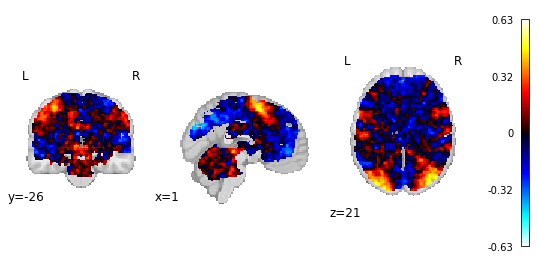

In [16]:
_ = plot_stat_map(meanexp, draw_cross=False)

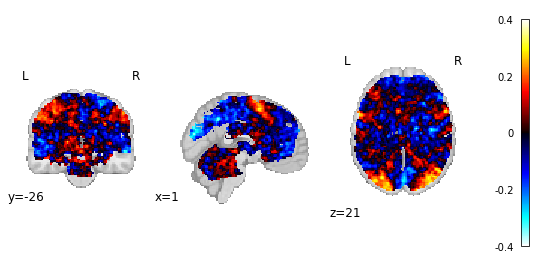

In [15]:
_ = plot_stat_map(meanunexp, draw_cross=False)

In [17]:
n_subjects = 35
subject = [f'sub-{i:03d}' for i in range(1, 36)]
condition_effect = np.hstack(([1] * n_subjects, [-1] * n_subjects))
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=["expected vs unexpected"] + subject,
)

In [18]:
paired_design_matrix

,expected vs unexpected,sub-001,sub-002,sub-003,sub-004,sub-005,sub-006,sub-007,sub-008,sub-009,...,sub-026,sub-027,sub-028,sub-029,sub-030,sub-031,sub-032,sub-033,sub-034,sub-035
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
66,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
67,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
68,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
second_level_model_paired = SecondLevelModel().fit(
    exp_maps+unexp_maps, design_matrix=paired_design_matrix
)

In [20]:
stat_maps_paired = second_level_model_paired.compute_contrast(
    "expected vs unexpected", output_type="all"
)

In [29]:
thresholded_map, threshold = threshold_stats_img(
    stat_maps_paired["z_score"],
    alpha=0.001,
    height_control="fpr",
    cluster_threshold=15,
    two_sided=True,
)

In [30]:
threshold

3.2905267314918945

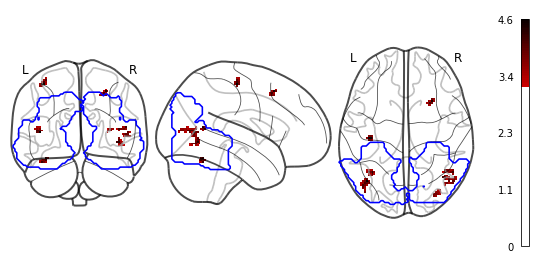

In [31]:
disp=plot_glass_brain(
    thresholded_map,
    threshold=threshold,
    colorbar=True,
    draw_cross=True
)
disp.add_contours('../../anat_roi_masks/ba-19-37.nii', linewidths=1.6, levels=[0.3], colors=['blue'])

In [32]:
get_clusters_table(stat_maps_paired['z_score'], threshold,
                   cluster_threshold=15, two_sided=True)

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-42.0,-68.0,6.0,4.586719,328
1,1a,-44.0,-80.0,8.0,3.807091,
2,2,-40.0,-22.0,58.0,4.561421,168
3,3,42.0,-64.0,-4.0,4.374379,240
4,4,-36.0,-58.0,-22.0,4.352279,176
5,5,42.0,-56.0,10.0,4.222880,136
6,5a,50.0,-58.0,12.0,4.197578,
7,6,50.0,-68.0,4.0,3.984417,144
8,7,32.0,-82.0,8.0,3.859704,128
9,1,28.0,18.0,50.0,-4.474368,152


In [112]:
binmask = nb.load('../../anat_roi_masks/ba-19-37.nii').get_fdata()

In [114]:
np.clip(thresholded_map.get_fdata(), 0, 1).sum()

114.0

In [90]:
binmask = new_img_like('../../anat_roi_masks/ba-19-37.nii', np.clip(thresholded_map.get_fdata(), 0, 1))

In [92]:
nb.save(binmask, '/project/3018040.07/anat_roi_masks/ba-19-37-infocoupling.nii')

In [94]:
sorted(glob('/project/3018040.07/anat_roi_masks/*.nii'))

['/project/3018040.07/anat_roi_masks/LO.nii',
 '/project/3018040.07/anat_roi_masks/LO_L.nii',
 '/project/3018040.07/anat_roi_masks/LO_R.nii',
 '/project/3018040.07/anat_roi_masks/PPA-L.nii',
 '/project/3018040.07/anat_roi_masks/PPA-R.nii',
 '/project/3018040.07/anat_roi_masks/PPA.nii',
 '/project/3018040.07/anat_roi_masks/RSC-L.nii',
 '/project/3018040.07/anat_roi_masks/RSC-R.nii',
 '/project/3018040.07/anat_roi_masks/RSC.nii',
 '/project/3018040.07/anat_roi_masks/TOS.nii',
 '/project/3018040.07/anat_roi_masks/ba-1-2-3.nii',
 '/project/3018040.07/anat_roi_masks/ba-17-18-19-37.nii',
 '/project/3018040.07/anat_roi_masks/ba-17-18-19-37_L.nii',
 '/project/3018040.07/anat_roi_masks/ba-17-18-19-37_R.nii',
 '/project/3018040.07/anat_roi_masks/ba-17-18.nii',
 '/project/3018040.07/anat_roi_masks/ba-17-18_L.nii',
 '/project/3018040.07/anat_roi_masks/ba-17-18_R.nii',
 '/project/3018040.07/anat_roi_masks/ba-17.nii',
 '/project/3018040.07/anat_roi_masks/ba-17_L.nii',
 '/project/3018040.07/anat_roi_

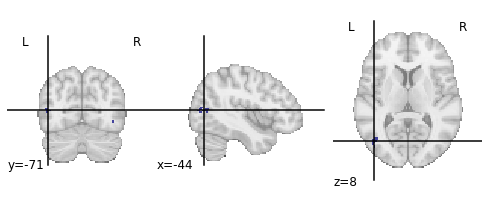

In [91]:
from nilearn.plotting import plot_roi
plot_roi(binmask)

In [77]:
sorted(glob('../../anat_roi_masks/*'))

['../../anat_roi_masks/LO.nii',
 '../../anat_roi_masks/LO_L.nii',
 '../../anat_roi_masks/LO_R.nii',
 '../../anat_roi_masks/PPA-L.nii',
 '../../anat_roi_masks/PPA-R.nii',
 '../../anat_roi_masks/PPA.nii',
 '../../anat_roi_masks/RSC-L.nii',
 '../../anat_roi_masks/RSC-R.nii',
 '../../anat_roi_masks/RSC.nii',
 '../../anat_roi_masks/TOS.nii',
 '../../anat_roi_masks/ba-1-2-3.nii',
 '../../anat_roi_masks/ba-17-18.nii',
 '../../anat_roi_masks/ba-17-18_L.nii',
 '../../anat_roi_masks/ba-17-18_R.nii',
 '../../anat_roi_masks/ba-17_L.nii',
 '../../anat_roi_masks/ba-17_R.nii',
 '../../anat_roi_masks/ba-18_L.nii',
 '../../anat_roi_masks/ba-18_R.nii',
 '../../anat_roi_masks/ba-19-37.nii',
 '../../anat_roi_masks/ba-19-37_L.nii',
 '../../anat_roi_masks/ba-19-37_R.nii',
 '../../anat_roi_masks/ba-19.nii',
 '../../anat_roi_masks/ba-19_L.nii',
 '../../anat_roi_masks/ba-19_R.nii',
 '../../anat_roi_masks/ba-39-40.nii',
 '../../anat_roi_masks/ba-4.nii',
 '../../anat_roi_masks/ba-40.nii',
 '../../anat_roi_masks/

In [44]:
threshold1

3.2905267314918945

In [13]:
expmap.shape

(79, 95, 79)

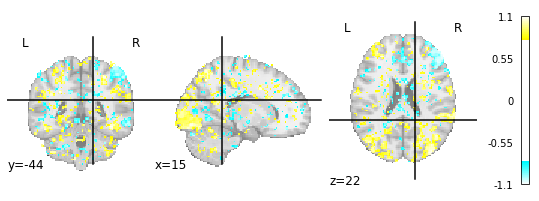

In [8]:
plot_stat_map('../../FIR_correlations/ba-17-18_contr-objscrvsbas_top-500/sub-034_exp.nii', threshold=0.8)

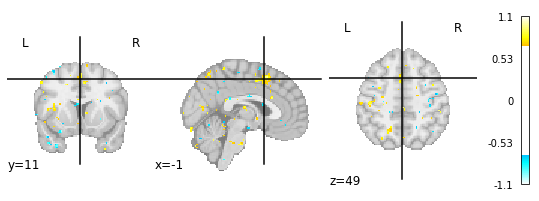

In [6]:
plot_stat_map('../../FIR_correlations/ba-17-18_contr-objscrvsbas_top-500/sub-034_unexp.nii', threshold=0.7)

In [2]:
tc = pd.read_csv('infocoupling/FIR_timecourses/sub-001_ba-17-18_contr-objscrvsbas_top-500.csv')
n_timepoints = tc.delay.nunique()
tc = tc.groupby(['delay', 'expected']).mean().reset_index()

In [3]:
tc.testmodel.unique()

array([15.])

In [4]:
opt = Options(
    sub='sub-001',
    task='test',
    model=27
)

In [5]:
wholebrainDS = load_betas(opt, mask_templ=None, fir=True)

  0%|          | 0/329 [00:00<?, ?it/s]

 * Please note: warnings are printed only once, but underlying problem might occur many times *


100%|██████████| 329/329 [03:05<00:00,  1.77it/s]


In [6]:
wholebrainDS.a.voxel_dim

(79, 95, 79)

In [7]:
wholebrainDS.fa.voxel_indices.shape

(592892, 3)

In [8]:
np.max(wholebrainDS.fa.voxel_indices, axis=0)

array([78, 94, 78])

In [9]:
n_voxels = wholebrainDS.samples.shape[1]
wholebrainDS = split_expunexp(wholebrainDS)
nanmask = np.all(np.isfinite(wholebrainDS.samples), axis=0)
wholebrainDS = wholebrainDS[:, nanmask]

In [10]:
wholebrainDS.samples.shape

(280, 206537)

In [11]:
univar_df = pd.DataFrame(
        {'delay': wholebrainDS.sa.delay,
         'expected': wholebrainDS.sa.expected,
         'samples': list(wholebrainDS.samples)}
    )
univar_df = univar_df.groupby(['delay', 'expected']).mean().reset_index()

In [12]:
# Get (n. voxels x n. timepoints) arrays for exp and unexp
exp_univar_array = np.vstack(univar_df[univar_df.expected==1].samples).T
unexp_univar_array = np.vstack(univar_df[univar_df.expected==0].samples).T
# Normalize
exp_univar_array = (exp_univar_array - np.mean(exp_univar_array, axis=1, keepdims=True))/np.std(exp_univar_array, axis=1, keepdims=True)
unexp_univar_array = (unexp_univar_array - np.mean(unexp_univar_array, axis=1, keepdims=True))/np.std(unexp_univar_array, axis=1, keepdims=True)

In [13]:
# Same thing for multivariate sequence
exp_multivar_array = np.hstack(tc[tc.expected==True].distance).reshape(1, n_timepoints)
unexp_multivar_array = np.hstack(tc[tc.expected==False].distance).reshape(1, n_timepoints)
exp_multivar_array = (exp_multivar_array - np.mean(exp_multivar_array, axis=1, keepdims=True))/np.std(exp_multivar_array, axis=1, keepdims=True)
unexp_multivar_array = (unexp_multivar_array - np.mean(unexp_multivar_array, axis=1, keepdims=True))/np.std(unexp_multivar_array, axis=1, keepdims=True)

In [14]:
# Compute Pearsons correlations
exp_corrs = np.dot(exp_univar_array, exp_multivar_array.T)/(n_timepoints-1)
unexp_corrs = np.dot(unexp_univar_array, unexp_multivar_array.T)/(n_timepoints-1)

In [15]:
# Convert into brain maps
i, j, k = wholebrainDS.fa.voxel_indices.T

exp_map = np.full(wholebrainDS.a.voxel_dim, np.nan)
exp_map[i, j, k] = exp_corrs.flatten()
exp_map = new_img_like('/project/3018040.05/anat_roi_masks/wholebrain.nii', exp_map)

unexp_map = np.full(wholebrainDS.a.voxel_dim, np.nan)
unexp_map[i, j, k] = unexp_corrs.flatten()
unexp_map = new_img_like('/project/3018040.05/anat_roi_masks/wholebrain.nii', unexp_map)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


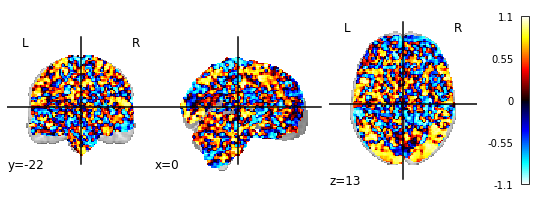

In [16]:
plot_stat_map(exp_map)

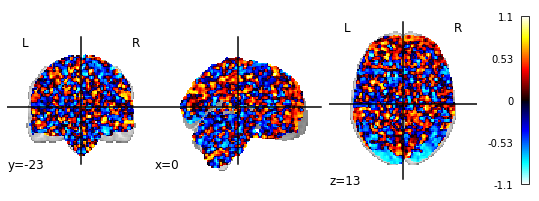

In [17]:
plot_stat_map(unexp_map)

In [20]:
nb.save(exp_map, 'exp_map.nii')

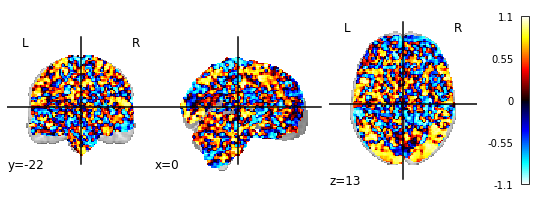

In [21]:
plot_stat_map('exp_map.nii')